In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import time
import requests
import json
import obspy
from obspy.clients.fdsn import Client

## 1. Configuration

In [2]:
region_name = "Ridgecrest_demo"
center = (-117.504, 35.705)
horizontal_degree = 1.0
vertical_degree = 1.0
starttime = obspy.UTCDateTime("2019-07-04T17")
endtime = obspy.UTCDateTime("2019-07-04T18")
client = "SCEDC"
network_list = ["CI"]
# channel_list = "HH*,BH*,EH*,HN*"
channel_list = "HH*,BH*,EH*"

config = {}
config["region"] = region_name
config["center"] = center
config["xlim_degree"] = [center[0] - horizontal_degree / 2, center[0] + horizontal_degree / 2]
config["ylim_degree"] = [center[1] - vertical_degree / 2, center[1] + vertical_degree / 2]
config["starttime"] = starttime.datetime.isoformat()
config["endtime"] = endtime.datetime.isoformat()
config["networks"] = network_list
config["channels"] = channel_list
config["client"] = client

In [3]:
config

{'region': 'Ridgecrest_demo',
 'center': (-117.504, 35.705),
 'xlim_degree': [-118.004, -117.004],
 'ylim_degree': [35.205, 36.205],
 'starttime': '2019-07-04T17:00:00',
 'endtime': '2019-07-04T18:00:00',
 'networks': ['CI'],
 'channels': 'HH*,BH*,EH*',
 'client': 'SCEDC'}

## 2. Download event information

In [4]:
events = Client("iris").get_events(
    starttime=config["starttime"],
    endtime=config["endtime"],
    minlongitude=config["xlim_degree"][0],
    maxlongitude=config["xlim_degree"][1],
    minlatitude=config["ylim_degree"][0],
    maxlatitude=config["ylim_degree"][1],
)

## 3. Download station information

In [5]:
stations = Client(config["client"]).get_stations(
    network=",".join(config["networks"]),
    station="*",
    starttime=config["starttime"],
    endtime=config["endtime"],
    minlongitude=config["xlim_degree"][0],
    maxlongitude=config["xlim_degree"][1],
    minlatitude=config["ylim_degree"][0],
    maxlatitude=config["ylim_degree"][1],
    channel=config["channels"],
    level="response",
)

## 3.1 Convert station information into csv

In [6]:
station_locs = defaultdict(dict)
for network in stations:
    for station in network:
        for chn in station:
            sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
            if sid in station_locs:
                station_locs[sid]["component"] += f",{chn.code[-1]}"
                station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
            else:
                component = f"{chn.code[-1]}"
                response = f"{chn.response.instrument_sensitivity.value:.2f}"
                dtype = chn.response.instrument_sensitivity.input_units.lower()
                tmp_dict = {}
                tmp_dict["longitude"], tmp_dict["latitude"], tmp_dict["elevation_m"] = (
                    chn.longitude,
                    chn.latitude,
                    chn.elevation,
                )
                tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                station_locs[sid] = tmp_dict

station_locs = pd.DataFrame.from_dict(station_locs, orient='index')
station_locs["station_id"] = station_locs.index

## 4. Download waveform

In [7]:
client = Client(config["client"])
interval = 30 #s
# interval = 3600 #s

# for event in events:
def downlad(event, stations):
    starttime = event["origins"][0].time
    endtime = starttime + interval

    max_retry = 10
    stream = obspy.Stream()
    num_sta = 0
    for network in stations:
        for station in network:
            print(f"********{network.code}.{station.code}********")
            retry = 0
            while retry < max_retry:
                try:
                    tmp = client.get_waveforms(
                        network.code, station.code, "*", config["channels"], starttime, endtime
                    )
                    for trace in tmp:
                        if trace.stats.sampling_rate != 100:
                            # print(trace)
                            trace = trace.interpolate(100, method="linear")
                    #      trace = trace.detrend("spline", order=2, dspline=5*trace.stats.sampling_rate)
                    #      stream.append(trace)
                    stream += tmp
                    num_sta += len(tmp)
                    break
                except Exception as err:
                    print("Error {}.{}: {}".format(network.code, station.code, err))
                    message = "No data available for request."
                    if str(err)[: len(message)] == message:
                        break
                    retry += 1
                    time.sleep(5)
                    continue
            if retry == max_retry:
                print(f"{fname}: MAX {max_retry} retries reached : {network.code}.{station.code}")

    # stream.attach_response(stations)
    # stream = stream.remove_sensitivity()
    return stream

In [8]:
mseed = downlad(events[0], stations)

********CI.CCC********
********CI.CLC********
********CI.DTP********
********CI.JRC2********
********CI.LRL********
********CI.MPM********
********CI.SLA********
********CI.SRT********
********CI.TOW2********
********CI.WBM********
********CI.WCS2********
********CI.WMF********
********CI.WNM********
********CI.WRC2********
********CI.WRV2********
********CI.WVP2********


## 5. Convert waveform to numpy

In [9]:
sampling_rate = 100
n_channel = 3
dtype = "float32"
amplitude = True
remove_resp = True

def convert_mseed(mseed, station_locs):
    try:
        mseed = mseed.detrend("spline", order=2, dspline=5 * mseed[0].stats.sampling_rate)
    except:
        logging.error(f"Error: spline detrend failed at file {fname}")
        mseed = mseed.detrend("demean")
    mseed = mseed.merge(fill_value=0)
    starttime = min([st.stats.starttime for st in mseed])
    endtime = max([st.stats.endtime for st in mseed])
    mseed = mseed.trim(starttime, endtime, pad=True, fill_value=0)

    for i in range(len(mseed)):
        if mseed[i].stats.sampling_rate != sampling_rate:
            logging.warning(
                f"Resampling {mseed[i].id} from {mseed[i].stats.sampling_rate} to {sampling_rate} Hz"
            )
            mseed[i] = mseed[i].interpolate(sampling_rate, method="linear")

    order = ['3', '2', '1', 'E', 'N', 'Z']
    order = {key: i for i, key in enumerate(order)}
    comp2idx = {"3": 0, "2": 1, "1": 2, "E": 0, "N": 1, "Z": 2}

    nsta = len(station_locs)
    nt = max(len(mseed[i].data) for i in range(len(mseed)))
    data = []
    station_id = []
    t0 = []
    for i in range(nsta):
        trace_data = np.zeros([nt, n_channel], dtype=dtype)
        empty_station = True
        # sta = station_locs.iloc[i]["station"]
        sta = station_locs.index[i]
        comp = station_locs.iloc[i]["component"].split(",")
        if remove_resp:
            resp = station_locs.iloc[i]["response"].split(",")
            # resp = station_locs.iloc[i]["response"]

        for j, c in enumerate(sorted(comp, key=lambda x: order[x[-1]])):

            resp_j = float(resp[j])
            if len(comp) != 3:  ## less than 3 component
                j = comp2idx[c]

            if len(mseed.select(id=sta + c)) == 0:
                print(f"Empty trace: {sta+c} {starttime}")
                continue
            else:
                empty_station = False

            tmp = mseed.select(id=sta + c)[0].data.astype(dtype)
            trace_data[: len(tmp), j] = tmp[:nt]

            if station_locs.iloc[i]["unit"] == "m/s**2":
                tmp = mseed.select(id=sta + c)[0]
                tmp = tmp.integrate()
                tmp = tmp.filter("highpass", freq=1.0)
                tmp = tmp.data.astype(dtype)
                trace_data[: len(tmp), j] = tmp[:nt]
            elif station_locs.iloc[i]["unit"] == "m/s":
                tmp = mseed.select(id=sta + c)[0].data.astype(dtype)
                trace_data[: len(tmp), j] = tmp[:nt]
            else:
                print(
                    f"Error in {station_locs.iloc[i]['station']}\n{station_locs.iloc[i]['unit']} should be m/s**2 or m/s!"
                )

            if remove_resp:
                trace_data[:, j] /= resp_j

        if not empty_station:
            data.append(trace_data)
            station_id.append(sta)
            t0.append(starttime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3])

    data = np.stack(data)

    meta = {"data": data, "t0": t0, "station_id": station_id, "fname": station_id}


    return meta

In [10]:
meta = convert_mseed(mseed, station_locs)

## 6. Pick P/S picks using PhaseNet

In [11]:
# PHASENET_API_URL = "http://127.0.0.1:8000"
PHASENET_API_URL = "https://ai4eps-eqnet.hf.space"


batch = 4
phasenet_picks = []
for j in range(0, len(meta["station_id"]), batch):
    req = {"id": [[x] for x in meta["station_id"][j:j+batch]],
        "timestamp": meta["t0"][j:j+batch],
        "vec": meta["data"][j:j+batch].tolist()}

    resp = requests.post(f'{PHASENET_API_URL}/predict', json=req)
    phasenet_picks.extend(resp.json())

print('PhaseNet picks', pd.DataFrame(phasenet_picks))


PhaseNet picks      station_id               phase_time  phase_score phase_type    dt
0    CI.CCC..BH  2019-07-04T17:58:07.368        0.952          P  0.01
1    CI.CCC..BH  2019-07-04T17:58:10.978        0.891          S  0.01
2    CI.CCC..HH  2019-07-04T17:58:07.398        0.952          P  0.01
3    CI.CCC..HH  2019-07-04T17:58:11.008        0.798          S  0.01
4    CI.CLC..BH  2019-07-04T17:58:05.478        0.959          P  0.01
..          ...                      ...          ...        ...   ...
57  CI.WRC2..HH  2019-07-04T17:58:08.038        0.983          P  0.01
58  CI.WRC2..HH  2019-07-04T17:58:12.048        0.803          S  0.01
59  CI.WRV2..EH  2019-07-04T17:58:10.948        0.959          P  0.01
60  CI.WRV2..EH  2019-07-04T17:58:17.068        0.551          S  0.01
61  CI.WVP2..EH  2019-07-04T17:58:09.578        0.352          P  0.01

[62 rows x 5 columns]


## 7. Associate picks using GaMMA

In [12]:
# GAMMA_API_URL = "http://127.0.0.1:8001"
GAMMA_API_URL = "https://ai4eps-gamma.hf.space"

stations_json = station_locs.to_dict(orient="records")

config = {}
config["use_amplitude"] = False
response = requests.post(f'{GAMMA_API_URL}/predict/', json= {"picks": {"data": phasenet_picks},
                                                          "stations": {"data": stations_json},
                                                          "config": config})

if response.status_code == 200:
    result = response.json()
    events_gamma = result["events"]
    picks_gamma = result["picks"]
    print("GaMMA catalog:")
    display(pd.DataFrame(events_gamma))
    print("GaMMA association:")
    display(pd.DataFrame(picks_gamma))
else:
    print(f"Request failed with status code: {response.status_code}")
    print(f"Error message: {response.text}")

GaMMA catalog:


time  magnitude  sigma_time  sigma_amp  cov_time_amp  \
0  2019-07-04T17:58:02.566        999    0.344259          0             0   

   gamma_score  num_picks  num_p_picks  num_s_picks  event_index   longitude  \
0    56.970255         57           29           28            1 -117.503559   

   latitude   depth_km  
0  35.70536  12.578723

GaMMA association:


station_id                  phase_time  phase_score phase_type    dt  \
0    CI.CCC..BH  2019-07-04T17:58:07.368000        0.952          P  0.01   
1    CI.CCC..BH  2019-07-04T17:58:10.978000        0.891          S  0.01   
2    CI.CCC..HH  2019-07-04T17:58:07.398000        0.952          P  0.01   
3    CI.CCC..HH  2019-07-04T17:58:11.008000        0.798          S  0.01   
4    CI.CLC..BH  2019-07-04T17:58:05.478000        0.959          P  0.01   
..          ...                         ...          ...        ...   ...   
57  CI.WRC2..HH  2019-07-04T17:58:08.038000        0.983          P  0.01   
58  CI.WRC2..HH  2019-07-04T17:58:12.048000        0.803          S  0.01   
59  CI.WRV2..EH  2019-07-04T17:58:10.948000        0.959          P  0.01   
60  CI.WRV2..EH  2019-07-04T17:58:17.068000        0.551          S  0.01   
61  CI.WVP2..EH  2019-07-04T17:58:09.578000        0.352          P  0.01   

    event_index  gamma_score  
0             1     0.667284  
1             1     0.362202  
2             1     0.631032  
3             1     0.294299  
4             1     0.491822  
..          ...          ...  
57            1     0.617376  
58            1     0.859684  
59            1     0.573461  
60            1     0.877037  
61            1     0.676099  

[62 rows x 7 columns]

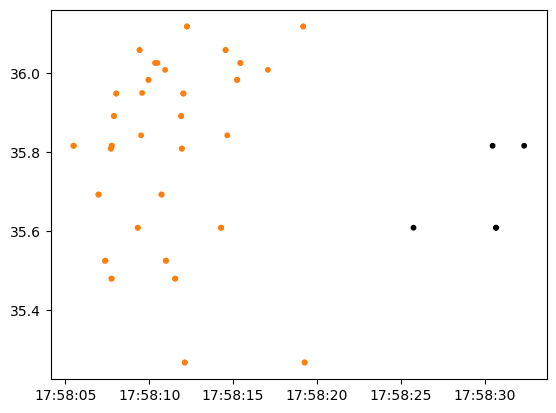

In [13]:
events_ = pd.DataFrame(result["events"])
picks_ = pd.DataFrame(result["picks"])
picks_["phase_time"] = pd.to_datetime(picks_["phase_time"])
picks_ = picks_.merge(station_locs[["station_id", "longitude", "latitude"]], on="station_id")

plt.figure()
mapping_color = lambda x: f"C{x}" if x!= -1 else "black"
plt.scatter(picks_["phase_time"], picks_["latitude"], c=picks_["event_index"].apply(mapping_color), s=10)

## Compare with official catalog

In [14]:
event = events[0]
print(event.origins[0])
print(event.magnitudes[0])

Origin
	   resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=39384936")
	          time: UTCDateTime(2019, 7, 4, 17, 58, 2, 620000)
	     longitude: -117.516998
	      latitude: 35.700832
	         depth: 2770.0
	 creation_info: CreationInfo(author='ci,us')
Magnitude
	    resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=195120172")
	            mag: 3.29
	 magnitude_type: 'Ml'
	  creation_info: CreationInfo(author='CI')
